In [1]:
import sys
import os
import subprocess
import tarfile
import shutil

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.generator import AdaLead
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm
from boda.model.mpra_basset import MPRA_Basset
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

# adjust the width of the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
class Attributer(nn.Module):
    def __init__(self,
                 sequence,
                 fitness_fn,
                 baseline=None,
                 padding_len=400,
                 num_samples=1,
                 **kwrags):
        super().__init__()
        self.sequence = sequence
        self.fitness_fn = fitness_fn  
        self.baseline = baseline
        self.padding_len = padding_len
        self.num_samples = num_samples

        try: fitness_fn.eval()
        except: pass

        self.seq_len = len(self.sequence)
        self.grad = torch.autograd.grad
    
        left_flank, right_flank = utils.create_paddingTensors(1, self.padding_len,
                                                                   self.num_samples, True)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 

        if type(self.sequence) == str:
            target_distribution = utils.dna2tensor(self.sequence).view(1, 4, -1)
        else:
            target_distribution = self.sequence.view(1, 4, -1)

        self.register_buffer('target_distribution', target_distribution)
        self.target_distribution.requires_grad_()

        if self.baseline == None:
            base_distribution = 0.25 * torch.ones_like(self.target_distribution)
            # base_distribution[0,0,:] = 0.3
            # base_distribution[0,1,:] = 0.2
            # base_distribution[0,2,:] = 0.3
            # base_distribution[0,3,:] = 0.2
            self.register_buffer('base_distribution', base_distribution)
        else:
            self.register_buffer('base_distribution', baseline.view(self.target_distribution.shape))
        self.base_distribution.requires_grad_()

    def pad(self, tensor, multi_sampling=True):
        if self.padding_len > 0:
            if not multi_sampling:
                size = tensor.shape
                left_flank, right_flank = self.left_flank[0].view(size), self.right_flank[0].view(size)
                return torch.cat([ left_flank, tensor, right_flank], dim=-1)
            else:
                return torch.cat([ self.left_flank, tensor, self.right_flank], dim=-1)
        else: 
            return tensor

    def get_samples(self, distribution):
        nucleotide_probs = Categorical(torch.transpose(distribution, 1, 2))
        sampled_idxs = nucleotide_probs.sample((self.num_samples, ))
        sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=4)        
        sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
        multi_distribution = distribution.repeat(self.num_samples, 1, 1, 1)
        sampled_nucleotides = sampled_nucleotides - multi_distribution.detach() + multi_distribution 
        return sampled_nucleotides

    def get_gradients(self, distribution):
        samples = self.get_samples(distribution)
        input = self.pad(samples).view(self.num_samples, 4, -1)
        fitnesses = self.fitness_fn(input).mean(dim=0)
        num_preds = fitnesses.shape[-1]
        gradients = []
        for idx in range(num_preds):
            gradients.append(self.grad(fitnesses[idx], distribution, retain_graph=True)[0])
        return torch.cat(gradients)

    def get_point_distribution(self, k):
        return self.base_distribution + k * (self.target_distribution - self.base_distribution)

    def integrate_gradients(self, num_steps=10):
        line_gradients = []
        for i in range(num_steps + 1):
            slope = i / num_steps
            point_distribution = self.get_point_distribution(slope)
            point_gradients = self.get_gradients(point_distribution)
            line_gradients.append(point_gradients)
        return torch.stack(line_gradients).mean(dim=0)

In [11]:
def plot_evol(traj, energy, step=1):
    timesteps, tokens, pos_ct = traj.shape
    x = np.linspace(0.5,pos_ct+0.5,pos_ct+1)
    y = np.linspace(0.,timesteps, (timesteps//step)+1) 
    x,y = np.meshgrid(x,y)
    z = traj.argmax(1).float().add(0.50).numpy()
    z = z[np.arange(0,timesteps,step)]
    z = np.flip(z, axis=0)
    cmap = mp.colors.ListedColormap(['g', 'y', 'r', 'b'])
    bounds = [0.,1.,2.,3.,4.]
    ticks = [0.5,1.5,2.5,3.5]
    norm = mp.colors.BoundaryNorm(bounds, cmap.N)
    divisor = 10
    if timesteps > divisor:
        y_size = timesteps//divisor
    else:
        y_size = timesteps//2
    fig, axes = plt.subplots(1, 2, figsize = (15, y_size), gridspec_kw={'width_ratios':[10,1]}, constrained_layout=True)
    ax = axes[0]
    p = ax.pcolormesh(x,y,z, cmap=cmap, norm = norm)
    ax.axis([x.min(),x.max(),y.min(),y.max()])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    cbar = fig.colorbar(p, ax=ax, boundaries = bounds, 
                        ticks = ticks, location='top',
                       shrink=0.5)
    cbar.set_ticklabels(constants.STANDARD_NT)
    
    ax = axes[1]
    ax.plot(energy[np.arange(0,timesteps,step)],np.flip(np.arange(timesteps//step)), linestyle='--', marker='*')
    ax.set_ylim([0,timesteps//step])
    
    plt.show()
    return plt, ax

def align_to_alphabet(in_tensor, in_alphabet=['A','C','G','T'], out_alphabet=constants.STANDARD_NT):
    permuted_idxs = []
    for nt in out_alphabet:
        permuted_idxs.append(in_alphabet.index(nt))
    permutation_idxs = torch.LongTensor(permuted_idxs)
    out_tensor = in_tensor[permutation_idxs, :]
    return out_tensor

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_alphabet=alphabet,  out_alphabet=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def show_streme_motifs(parsed_output):
    motif_dict = parsed_output['motif_results']
    results_alphabet = parsed_output['meta_data']['alphabet']
    for motif_idx in range(len(motif_dict)):
        motif_ppm = torch.tensor((motif_dict[motif_idx]['ppm']))
        motif_ppm = align_to_alphabet(motif_ppm, in_alphabet=results_alphabet)
        motif_ppm_rc = reverse_complement(motif_ppm)
        print(motif_dict[motif_idx]['summary'])
        matrix_to_dms(ppm_to_IC(motif_ppm), y_max=2)
        plt.show()
        matrix_to_dms(ppm_to_IC(motif_ppm_rc), y_max=2)
        plt.show()
        
def fasta_to_input_tensor(file_name, left_flank, right_flank):
    fasta_dict = {}
    with open(file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')
    seq_tensors = []
    for sequence in list(fasta_dict.values()):
        seq_tensors.append(utils.dna2tensor(sequence))
    sequences = torch.stack(seq_tensors, dim=0)
    pieces = [left_flank.repeat(sequences.shape[0], 1, 1), sequences,  right_flank.repeat(sequences.shape[0], 1, 1)]
    return torch.cat(pieces, axis=-1)

def plot3D_activities(activities_tensor, color='blue', fig_size=(15, 10), alpha=0.2, ax_lims=(-2, 8)):
    xdata = activities_tensor[:,0].cpu().detach().numpy()
    ydata = activities_tensor[:,1].cpu().detach().numpy()
    zdata = activities_tensor[:,2].cpu().detach().numpy()

    fig = plt.figure(figsize=fig_size)
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    xAxisLine = (ax_lims, (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), ax_lims, (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), ax_lims)
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
    dAxisLine = (ax_lims, ax_lims, ax_lims)
    ax.plot(dAxisLine[0], dAxisLine[1], dAxisLine[2], 'gray', linestyle='dashed')

    ax.scatter3D(xdata, ydata, zdata, c=color, alpha=alpha)
    ax.set_xlabel('K562')
    ax.set_ylabel('HepG2')
    ax.set_zlabel('SKNSH')
    ax.view_init(15, -45)
    
def unpickle_logs(log_path):
    log_df = pd.read_pickle(log_path + 'sequence_data.pkl')
    with open(log_path + 'pmms_list.pkl', 'rb') as fp:
        pmms_list = pickle.load(fp)
    return log_df, pmms_list

In [4]:
#----------------------- Artisanal model -----------------------
#! gsutil cp gs://syrgoth/checkpoints/manual_checkpoint_multioutput_lasthidden250_L1.ckpt ./

artisan_model = MPRA_Basset(extra_hidden_size = 250)
checkpoint = torch.load('manual_checkpoint_multioutput_lasthidden250_L1.ckpt')
artisan_model.load_state_dict(checkpoint['state_dict'])
artisan_model.eval()

MPRA_Basset(
  (criterion): MSELoss()
  (last_activation): Tanh()
  (basset_net): Basset(
    (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
    (conv1): Conv1dNorm(
      (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
      (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
    (conv2): Conv1dNorm(
      (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
      (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
    (conv3): Conv1dNorm(
      (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
      (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
    (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (maxpool_4): MaxPool1d(ker

In [5]:
def linexp_reward(x):
    return torch.exp(-x) - x - 1

def basic_reward(x):
    return x

def k562_score(x):
    return -linexp_reward(x[:,0]) + 0.5 * (linexp_reward( x[:,1]) + linexp_reward( x[:,2]))
# def k562_score(x):
#     return x[:,0] - torch.mean(x[:,1:], axis=1) 
def k562_fitness(x):
    scores = k562_score(x)
    return torch.mean(scores)

def hepg2_score(x):
    return -linexp_reward(x[:,1]) + 0.5 * (linexp_reward( x[:,2]) + linexp_reward( x[:,0]))
# def hepg2_score(x):
#     return x[:,1] - torch.mean(x[:, np.r_[0,2]], axis=1)
def hepg2_fitness(x):
    scores = hepg2_score(x)
    return torch.mean(scores)

def sknsh_score(x):
    return -linexp_reward(x[:,2]) + 0.5 * (linexp_reward( x[:,1]) + linexp_reward( x[:,0]))
# def hepg2_score(x):
#     return x[:,1] - torch.mean(x[:, np.r_[0,2]], axis=1)
def sknsh_fitness(x):
    scores = sknsh_score(x)
    return torch.mean(scores)

class energy_multipenalty(nn.Module):
    def __init__(self,
                 predictor,
                 loss_fn,
                 ppms=[],
                 score_pct=0,
                 ppms_alphabet=['A', 'C', 'G', 'T'],
                 backgrounds=None,                 
                 **kwrags):
        super().__init__()
        self.predictor = predictor
        self.loss_fn = loss_fn
        self.score_pct = score_pct
        self.ppms = ppms
        self.ppms_alphabet = ppms_alphabet
        
        self.num_ppms = len(self.ppms)      
             
        try: self.predictor.eval()
        except: pass
        
        if len(self.ppms) == 0:
            self.penalization_flag = False
            self.backgrounds = backgrounds
            self.filters = None
            self.score_thresholds = None
        else:
            self.penalization_flag = True
            self.max_ppm_len = max([ppm.shape[-1] for ppm in self.ppms])
            if backgrounds is None:
                self.backgrounds = [ 4*[0.25] for i in range(len(self.ppms))]
            self.filters_and_thresholds()
    
    def filters_and_thresholds(self):
        penalty_weight = len(self.ppms)
        pwms = []
        score_thresholds = []
        for ppm, background in zip(self.ppms, self.backgrounds):
            ppm = align_to_alphabet(ppm, in_alphabet=self.ppms_alphabet)
            pwm = ppm_to_pwm(ppm, background) * np.cbrt(penalty_weight)
            max_score = torch.max(pwm, dim=0)[0].sum()
            pwm_rc = reverse_complement(pwm)
            pwms += [pwm, pwm_rc]
            score_thresholds += 2 * [self.score_pct * max_score]
            penalty_weight -= 1 
        filters = [torch.cat([pwm, pwm.new_zeros(pwm.shape[0], self.max_ppm_len - pwm.shape[-1])], dim=1) for pwm in pwms]
        self.register_buffer('filters', torch.stack(filters, dim=0))
        self.register_buffer('score_thresholds', torch.tensor(score_thresholds))
                   
    def motif_penalty(self, x):
        if self.penalization_flag:
            motif_scores = F.conv1d(x, self.filters)
            score_thresholds = torch.ones_like(motif_scores) * self.score_thresholds[None, :, None]
            mask = torch.ge(motif_scores, score_thresholds) 
            masked_scores = torch.masked_select(motif_scores, mask)
            return masked_scores.sum(dim=-1).mean().div(self.num_ppms * x.shape[0])
        else:
            return 0
        
    def forward(self, x):
        motif_penalty = self.motif_penalty(x)
        preds = self.predictor(x)
        energy = self.loss_fn(preds) + motif_penalty
        return energy

In [37]:
num_proposed_sequences = 20
num_generations = 30

scoring_fn = k562_score
model = artisan_model

streme_results_list = []
ppms_list = []
results_alphabet = ['A', 'C', 'G', 'T']
results_backgrounds = []
top_ppms_summaries = []
score_pct = 0.25

fitness = energy_multipenalty(predictor=model,
                             loss_fn=scoring_fn,
                             ppms=ppms_list,
                             score_pct=score_pct,
                             streme_alphabet=results_alphabet,
                             streme_background=None)

start_time = datetime.now()

proposed_sequences = []
proposed_sequences_fitnesses = []
for i in range(num_proposed_sequences):
    description_str = f'Proposal {i+1}/{num_proposed_sequences}'
    
    generator = AdaLead(model_queries_per_batch = 800,
                        eval_batch_size = 10,                   #20  100
                        sequences_batch_size = 10,             #200 500
                        rho = 2,                               #50  40
                        threshold = 0.25,                        #0.1 0.25
                        recomb_rate = 0.1,                      #0.1 0.5
                        mu = 1,
                        fitness_fn = fitness)
    generator.cuda()
    generator.run(num_iterations=num_generations, desc_str=description_str)
    proposed_sequences.append(generator.new_seqs[0])
    proposed_sequences_fitnesses.append(generator.preds[0])

end_time = datetime.now()
print(f'{num_proposed_sequences} proposals generated in {end_time - start_time}')

Proposal 20/20: 100%|██████████| 30/30 [00:13<00:00,  2.30it/s, Initial top fitness=10.5, Final top fitness=10.5]

20 proposals generated in 0:04:09.314759


First sequence predictions = [ 6.019391  -1.0313809 -1.2727624]

Last sequence predictions = [ 6.0664706 -1.0455776 -1.2957851]



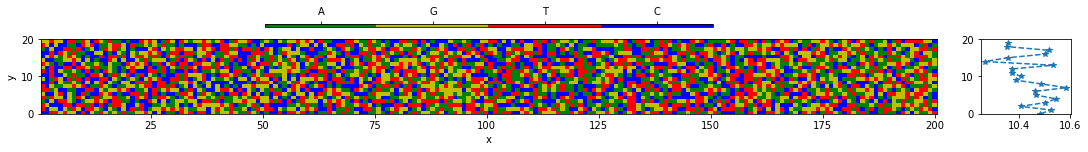

In [38]:
#final_batch = generator.string_list_to_tensor(generator.new_seqs)
final_batch = generator.string_list_to_tensor(proposed_sequences)

top_sequence = final_batch[0, :, :]
padded_top_sequence = attributer.pad(top_sequence.view(1,4,-1).cuda(), multi_sampling=False)
top_activity = model(padded_top_sequence).cpu().detach().numpy()[0]
print(f'First sequence predictions = {top_activity}')
print('')

bottom_sequence = final_batch[-1, :, :]
padded_bottom_sequence = attributer.pad(bottom_sequence.view(1,4,-1).cuda(), multi_sampling=False)
bottom_activity = model(padded_bottom_sequence).cpu().detach().numpy()[0]
print(f'Last sequence predictions = {bottom_activity}')
print('')

_ = plot_evol(final_batch, torch.tensor(proposed_sequences_fitnesses))

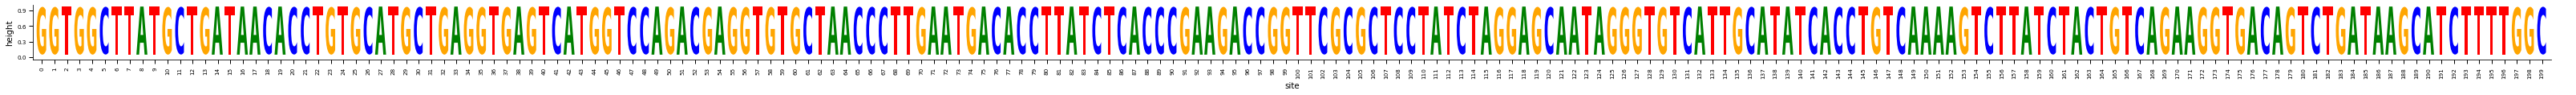

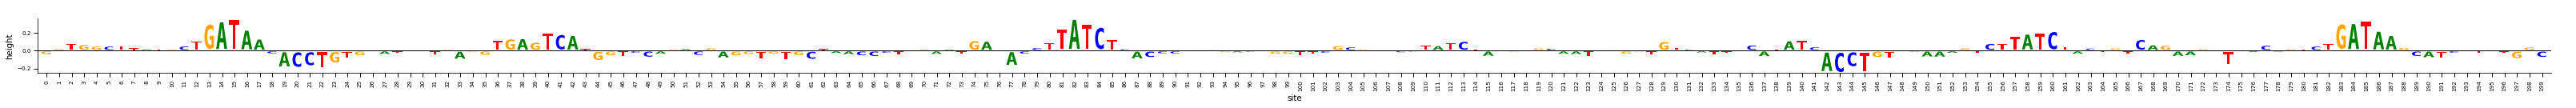

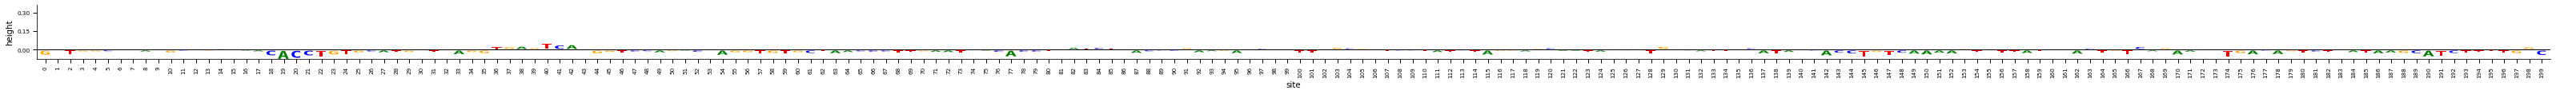

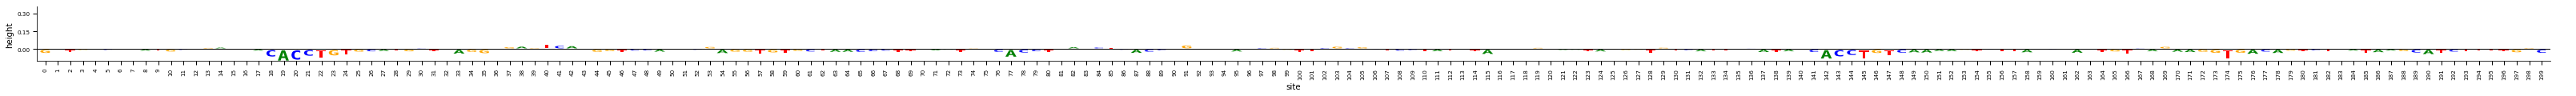

In [39]:
sequence_idx = 0
sequence_tensor = final_batch[sequence_idx,:,:].detach().view(4,-1).cuda()
attributer = Attributer(sequence=sequence_tensor,
                        fitness_fn=model,
                        num_samples=50)
attributer.cuda()
integrated_gradients = attributer.integrate_gradients(num_steps=200)

# input_tensor = attributer.pad(sequence_tensor.view(1,4,-1).cuda(), multi_sampling=False)
# preds = model(input_tensor).cpu().detach().numpy()[0]
# print(f'Approx Prediction Means = {preds}')
# print('')

fig, ax = matrix_to_dms(sequence_tensor, y_max=1)
plt.show()
print('')

contributions = (sequence_tensor.view(1,4,-1).repeat(3, 1, 1) * integrated_gradients)
y_max = torch.max(contributions).item()

for i in range(3):
    cell_contributions = contributions[i,:,:].detach()
    fig, ax = matrix_to_dms(cell_contributions, y_max=y_max)
    plt.show()

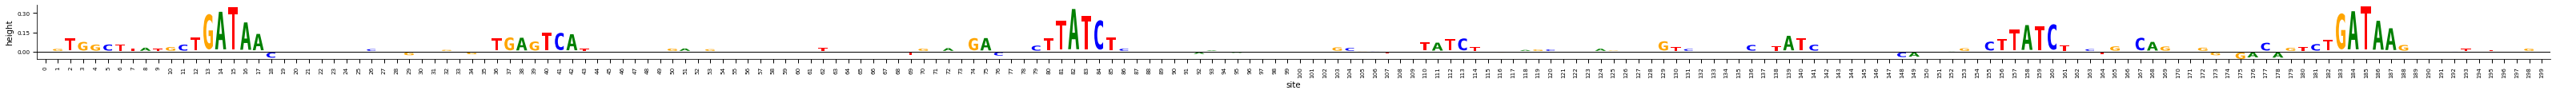

In [41]:
top_idx = 0
other_idx = 1
other_idx2 = 2

#lin_exp_contributions = linexp_reward(contributions[1,:,:])  - 0.5*(linexp_reward(contributions[0,:,:])  + linexp_reward(contributions[2,:,:]) )
spec_contributions = contributions[top_idx,:,:] - 0.5*(contributions[other_idx,:,:] + contributions[other_idx2,:,:])
positive_contributions =  spec_contributions * (contributions[top_idx,:,:] >= 0)
negative_contributions =  - spec_contributions * (contributions[top_idx,:,:] < 0)
#contributions = contributions[1,:,:] - 0.5*(contributions[0,:,:] + contributions[2,:,:])
specificity_contributions = positive_contributions * (positive_contributions >= 0) + linexp_reward(-negative_contributions) * (negative_contributions < 0)
#specificity_contributions = contributions * (contributions >= 0) - contributions * (contributions < 0)
y_max = torch.max(specificity_contributions).item()
fig, _ = matrix_to_dms(specificity_contributions, y_max=y_max)
plt.show()

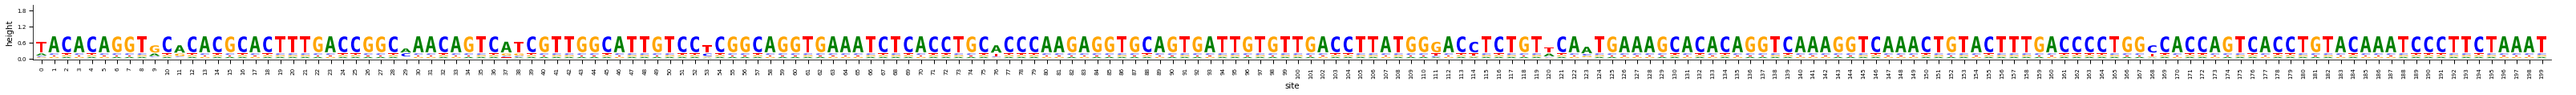

In [76]:
pseudocount = 1
batch_counts = torch.sum(final_batch, axis=0) + pseudocount
batch_ppm = counts_to_ppm(batch_counts)
batch_icm = ppm_to_IC(batch_ppm)
matrix_to_dms(batch_icm)
plt.show()

## Motif Penalization

In [3]:
def create_new_log_folder_in(super_folder):
    log_idx = 0
    folder_name = 'log_' + str(log_idx)
    while os.path.isdir(super_folder + folder_name):
        log_idx += 1
        folder_name = 'log_' + str(log_idx)
    log_path = super_folder + folder_name 
    os.makedirs(log_path)
    return log_path + '/'

def frame_print(string, marker='*', left_space=25):
    left_spacer = left_space * ' '
    string = marker + ' ' + string.upper() + ' ' + marker
    n = len(string)
    print('')
    print('')
    print(left_spacer + n * marker)
    print(left_spacer + string)
    print(left_spacer + n * marker)
    print('')
    print('')
    
def decor_print(string):
    decor = 15*'-'
    print('')
    print(decor + ' ' + string + ' ' + decor)
    print('')

In [ ]:
scoring_fn = k562_score
model = artisan_model

num_proposed_sequences = 100
num_generations = 30
penalty_iterations = 5

model_queries_per_batch = 500,
eval_batch_size = 20,                   #20  100
sequences_batch_size = 20,             #200 500
rho = 2,                               #50  40
threshold = 0.25,                        #0.1 0.25
recomb_rate = 0.1,                      #0.1 0.5
mu = 1,

score_pct = 0.5

settings = {'num_proposed_sequences': num_proposed_sequences,
            'num_generations:': num_generations,
            'model_queries_per_batch': model_queries_per_batch,
            'eval_batch_size': eval_batch_size,
            'threshold': threshold,
            'recomb_rate': recomb_rate,
            'mu', mu,
            'sequences_batch_size': sequences_batch_size,
            'rho': rho,
            'score_pct': score_pct,
            'loss_fn': str(loss_fn).lstrip('<function ')[:str(loss_fn).lstrip('<function ').find(' at')],
            'model': str(model)[:str(model).find('\n')-1]
           }


streme_results_list = []
ppms_list = []
results_alphabet = ['A', 'C', 'G', 'T']
results_backgrounds = []
top_ppms_summaries = []

log_path = create_new_log_folder_in('run_logs/')
os.makedirs(log_path + '/figures')
figures_path = log_path + '/figures/'
print(f'Files and logs will be saved in {log_path}')

fitness = energy_multipenalty(predictor=model,
                             loss_fn=scoring_fn,
                             ppms=ppms_list,
                             score_pct=score_pct,
                             streme_alphabet=results_alphabet,
                             streme_background=None)

start_time = datetime.now()

proposed_sequences = []
proposed_sequences_fitnesses = []
for i in range(num_proposed_sequences):
    description_str = f'Proposal {i+1}/{num_proposed_sequences}'
    
    generator = AdaLead(model_queries_per_batch = model_queries_per_batch,
                        eval_batch_size = eval_batch_size,                   #20  100
                        sequences_batch_size = sequences_batch_size,             #200 500
                        rho = rho,                               #50  40
                        threshold = threshold,                        #0.1 0.25
                        recomb_rate = recomb_rate,                      #0.1 0.5
                        mu = mu,
                        fitness_fn = fitness)
    generator.cuda()
    generator.run(num_iterations=num_generations, desc_str=description_str)
    proposed_sequences.append(generator.new_seqs[0])
    proposed_sequences_fitnesses.append(generator.preds[0])

end_time = datetime.now()
print(f'{num_proposed_sequences} proposals generated in {end_time - start_time}')